<a href="https://colab.research.google.com/github/hernss/MachineLearningCourse/blob/main/04_transfer_learning_in_tensorflow_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning in tensorflow Part 1: Feature Extraction

In [ ]:
!nvidia-smi

Wed Feb 15 19:46:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    31W /  70W |  13102MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Explore data

In [ ]:
## Download data
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zipref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zipref.extractall()
zipref.close()


--2023-02-15 19:47:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  24.5MB/s    in 7.9s    

2023-02-15 19:47:10 (20.3 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
import os

# Walk throught directories

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/test'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger

## Creating data loaders

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "/content/10_food_classes_10_percent/train/"
test_dir = "/content/10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print("Training Images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")


Training Images:
Found 750 images belonging to 10 classes.
Test images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it overfit) with EarlyStopping callback

In [ ]:
# Create TensorBoard callback
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)
  print(f"Saving Tensorboard log files to: {log_dir}")
  return tensorboard_callback


# Creating model with tensorflo hub

Pretrained models at: https://tfhub.dev/

In [ ]:
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"


## Creating a resnet model

In [ ]:
# Import dependecies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

def create_model(model_url, num_classes=10):
  """
  Take a tensorflow Hub url and creates a keras sequential model with it

  Args:
    model_url (str): A tensorflow hub feature extraction
    num_classes (int): Number of target classes

  Returns:
    A uncompiled Keras sequential model 
  """

  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))
  
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model


In [ ]:
resnet_model = create_model(resnet_url, train_data.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Compile the model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])



In [ ]:
tensorboard_callback = create_tensorboard_callback("tensorflow_hub", "resnet50v2")

resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[tensorboard_callback])

Saving Tensorboard log files to: tensorflow_hub/resnet50v2/20230215-19471676490437
Epoch 1/5
24/24 [==============================] - 38s 1s/step - loss: 1.7511 - accuracy: 0.4027 - val_loss: 1.1592 - val_accuracy: 0.6436
Epoch 2/5
24/24 [==============================] - 21s 873ms/step - loss: 0.8267 - accuracy: 0.7560 - val_loss: 0.8781 - val_accuracy: 0.7100
Epoch 3/5
24/24 [==============================] - 22s 932ms/step - loss: 0.5899 - accuracy: 0.8320 - val_loss: 0.7562 - val_accuracy: 0.7528
Epoch 4/5
24/24 [==============================] - 21s 896ms/step - loss: 0.4419 - accuracy: 0.8893 - val_loss: 0.7033 - val_accuracy: 0.7652
Epoch 5/5
24/24 [==============================] - 18s 764ms/step - loss: 0.3596 - accuracy: 0.9147 - val_loss: 0.6934 - val_accuracy: 0.7720


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss_curves(history):
  """
  Args:
    history: TensorFlow History object
  
  Returns:
   Plots loss curves for training and validation metrics
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(loss))

  plt.plot(epochs, loss, label="Training loss")
  plt.plot(epochs, val_loss, label="Validation Loss")
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label="Training accuracy")
  plt.plot(epochs, val_accuracy, label="Validation Accuracy")
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend()

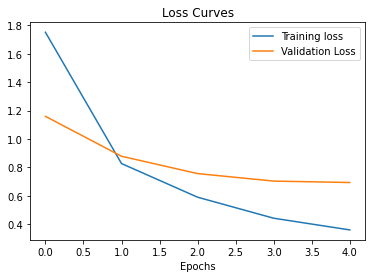

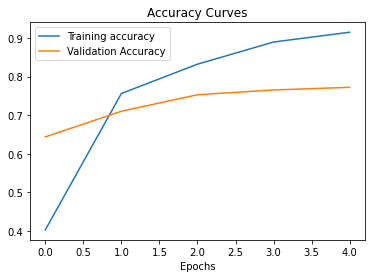

In [ ]:
plot_loss_curves(resnet_history)

## Creating a efficientnet model

In [ ]:
efficientnet_model = create_model(efficientnet_url,
                                  num_classes=train_data.num_classes)

efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

tensorboard_callback = create_tensorboard_callback("tensorflow_hub", "efficientnetB0")

efficientnet_history = efficientnet_model.fit(train_data, epochs=5, steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=len(test_data), callbacks=[tensorboard_callback])

Saving Tensorboard log files to: tensorflow_hub/efficientnetB0/20230215-19491676490595
Epoch 1/10
24/24 [==============================] - 31s 728ms/step - loss: 1.8690 - accuracy: 0.4227 - val_loss: 1.3162 - val_accuracy: 0.7248
Epoch 2/10
24/24 [==============================] - 15s 662ms/step - loss: 1.0809 - accuracy: 0.7627 - val_loss: 0.8802 - val_accuracy: 0.8092
Epoch 3/10
24/24 [==============================] - 16s 681ms/step - loss: 0.7679 - accuracy: 0.8280 - val_loss: 0.7134 - val_accuracy: 0.8372
Epoch 4/10
24/24 [==============================] - 16s 681ms/step - loss: 0.6176 - accuracy: 0.8693 - val_loss: 0.6174 - val_accuracy: 0.8520
Epoch 5/10
24/24 [==============================] - 16s 706ms/step - loss: 0.5196 - accuracy: 0.8853 - val_loss: 0.5626 - val_accuracy: 0.8612
Epoch 6/10
24/24 [==============================] - 16s 697ms/step - loss: 0.4517 - accuracy: 0.9053 - val_loss: 0.5242 - val_accuracy: 0.8676
Epoch 7/10
24/24 [==============================] - 16s

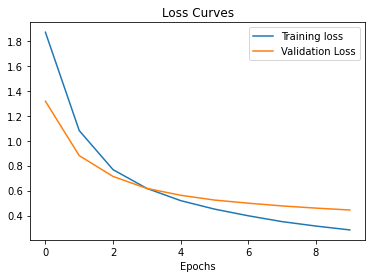

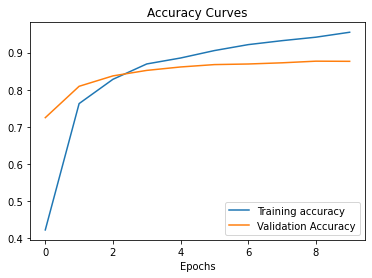

In [ ]:
plot_loss_curves(efficientnet_history)

## Comparing our models using TensorBoard

In [ ]:
!tensorboard dev upload --logdir ./tensorflow_hub/ --name "EfficientNetB0 vs ResNet50V2" --description "Comparing two different TF Hub model architecture" --one_shot

2023-02-15 19:53:16.002754: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-15 19:53:16.002865: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-15 19:53:16.002883: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoar

In [ ]:
!tensorboard dev list


2023-02-15 19:58:23.305764: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-15 19:58:23.305901: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-15 19:58:23.305928: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
https://tensorboard.dev/experiment/hZ6hAMpQQKSvooY7OlYSZQ/
	Name                 EfficientNetB0 vs ResNet50V2
	Description          Comparing two different TF Hub mode

In [ ]:
!tensorboard dev delete --experiment_id=hZ6hAMpQQKSvooY7OlYSZQ

2023-02-15 19:58:56.593599: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-15 19:58:56.593700: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-15 19:58:56.593718: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Deleted experiment hZ6hAMpQQKSvooY7OlYSZQ.


In [ ]:
!tensorboard dev list


2023-02-15 19:59:12.059111: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-15 19:59:12.059216: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-15 19:59:12.059247: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
No experiments. Use `tensorboard dev upload` to get started.
